# Exploring the model code

The model code is contained in the `wals_ml_engine` directory. The code's 
high-level functionality is implemented by the following files:

`mltrain.sh`
 * Launches various types of ML Engine jobs. This shell
      script accepts arguments for the location of the dataset file, the
      delimiter used to separate values in the file, and whether the data
      file has a header line. It's a best practice to create a script that
      automatically configures and executes ML Engine jobs.

`task.py`
 * Parses the arguments for the ML Engine job and executes
      training.

`model.py`
 * Loads the dataset.
 * Creates two sparse matrices from the data, one for  training and one for
      testing. Executes WALS on the training sparse matrix of ratings.

`wals.py`
 * Creates the WALS model.
 * Executes the WALS algorithm.
 * Calculates the root-mean-square error [RMSE](https://wikipedia.org/wiki/Root-mean-square_deviation) for a set of row/column factors and a ratings matrix.

## Let's run some code

Now we will run some of the code from `model.py` in this notebook, to help you understand it.

**Execute the following cell to import necessary python modules:**

In [21]:
import datetime
import numpy as np
import pandas as pd
from scipy.sparse import coo_matrix
import tensorflow as tf

## The MovieLens data set

**Execute the following cell to download the MovieLens 100k data set:**

In [3]:
!curl -O 'http://files.grouplens.org/datasets/movielens/ml-100k.zip'
!unzip ml-100k.zip
!mkdir -p ../data
!cp ml-100k/u.data ../data/

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 4808k  100 4808k    0     0  8086k      0 --:--:-- --:--:-- --:--:-- 8081k
Archive:  ml-100k.zip
   creating: ml-100k/
  inflating: ml-100k/allbut.pl       
  inflating: ml-100k/mku.sh          
  inflating: ml-100k/README          
  inflating: ml-100k/u.data          
  inflating: ml-100k/u.genre         
  inflating: ml-100k/u.info          
  inflating: ml-100k/u.item          
  inflating: ml-100k/u.occupation    
  inflating: ml-100k/u.user          
  inflating: ml-100k/u1.base         
  inflating: ml-100k/u1.test         
  inflating: ml-100k/u2.base         
  inflating: ml-100k/u2.test         
  inflating: ml-100k/u3.base         
  inflating: ml-100k/u3.test         
  inflating: ml-100k/u4.base         
  inflating: ml-100k/u4.test         
  inflating: ml-100k/u5.base         
  inflating: ml-100k/u5.test       

**Let's take a look at the MovieLens data.** It consists of rows of individual user ratings of movies.  Each row consists of four elements: a unique user id, a unique 'item id' corresponding to a movie, a rating from 1-5, and a timestamp of when the rating was made.  Each row of data maps to a single entry in the ratings matrix:

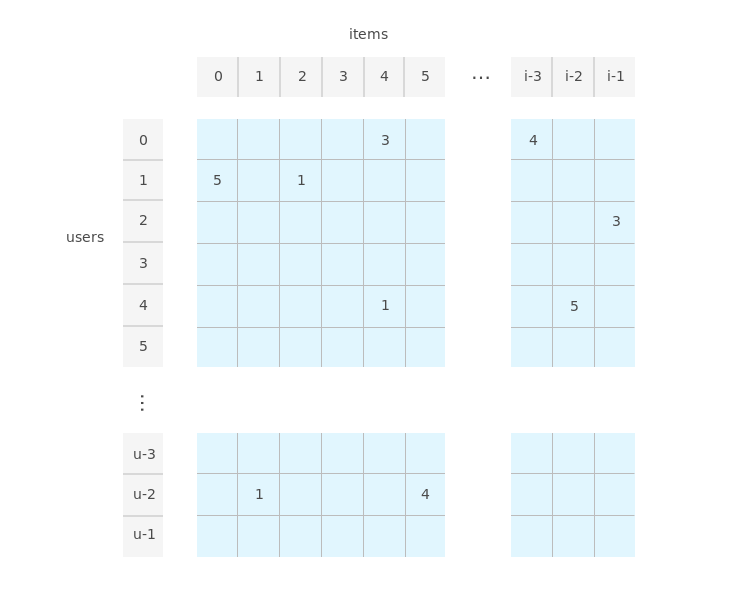

Let's inspect the contents of the file:

In [22]:
!head ../data/u.data

196	242	3	881250949
186	302	3	891717742
22	377	1	878887116
244	51	2	880606923
166	346	1	886397596
298	474	4	884182806
115	265	2	881171488
253	465	5	891628467
305	451	3	886324817
6	86	3	883603013


This model ignores the timestamp.  We will only make use of the **user id**, **item** (or movie) **id**, and **rating**.

## How the model preprocesses data

The model code performs data preprocessing to create a sparse ratings matrix and prepare it for matrix factorization. 

**This involves the following steps:**

 * The model code loads rows of data from a delimited text file, in this case the MovieLens data. 

**Execute this cell to read the MovieLens data set into a Pandas dataframe:**

In [23]:
input_file = '../data/u.data'
headers = ['user_id', 'item_id', 'rating', 'timestamp']
header_row = None
ratings_df = pd.read_csv(input_file,
                         sep='\t',
                         names=headers,
                         header=header_row,
                         dtype={
                           'user_id': np.int32,
                           'item_id': np.int32,
                           'rating': np.float32,
                           'timestamp': np.int32,
                         })

 * The code establishes a 0-indexed set of unique IDs for users and items. This guarantees that a unique ID corresponds to specific row and column indexes of the sparse ratings matrix.
 
**Let's find the number of unique users and movies:**

In [24]:
np_users = ratings_df.user_id.values
np_items = ratings_df.item_id.values
unique_users = np.unique(np_users)
unique_items = np.unique(np_items)

n_users = unique_users.shape[0]
n_items = unique_items.shape[0]

In [25]:
n_users

943

In [26]:
n_items

1682

The MovieLens 100k data uses 1-based IDs where the lowest index of the unique set is 1. But the TensorFlow code assumes a starting index of zero.  The code handles this **by converting the Pandas dataframe to a numpy array and subtracting one from each index:**

In [27]:
ratings = ratings_df[['user_id', 'item_id', 'rating']].values
ratings[:,0] -= 1
ratings[:,1] -= 1

 * The model code randomly selects a test set of ratings. By default, 10% of the ratings are chosen for the test set. These ratings are removed from the training set and will be used to evaluate the predictive accuracy of the user and item factors.

In [28]:
TEST_SET_RATIO = 10

test_set_size = round(len(ratings) / TEST_SET_RATIO)
test_set_idx = np.random.choice(range(len(ratings)),
                                size=test_set_size, replace=False)
test_set_idx = sorted(test_set_idx)

ts_ratings = ratings[test_set_idx]
tr_ratings = np.delete(ratings, test_set_idx, axis=0)

 * Finally, the code creates a `scipy` sparse matrix in coordinate form (`coo_matrix`) that includes the user and item indexes and ratings. The `coo_matrix` object acts as a wrapper for a sparse matrix. It also performs validation of the user and ratings indexes, checking for errors in preprocessing:

In [29]:
u_tr, i_tr, r_tr = zip(*tr_ratings)
tr_sparse = coo_matrix((r_tr, (u_tr, i_tr)), shape=(n_users, n_items))

u_ts, i_ts, r_ts = zip(*ts_ratings)
test_sparse = coo_matrix((r_ts, (u_ts, i_ts)), shape=(n_users, n_items))

In [30]:
tr_sparse

<943x1682 sparse matrix of type '<class 'numpy.float64'>'
	with 90000 stored elements in COOrdinate format>

In [31]:
test_sparse

<943x1682 sparse matrix of type '<class 'numpy.float64'>'
	with 10000 stored elements in COOrdinate format>

## How the WALS Algorithm is implemented in TensorFlow

You can read the [solution online](https://wikipedia.org/wiki/Root-mean-square_deviation) to understand how the WALS algorithm is implemented in TensorFlow.

In [201]:
BUCKET = "gs://logdata-rjin"

In [52]:
!bash ../wals_ml_engine/mltrain.sh local ../data u.data ../wals_ml_engine/trainer

Sun Feb 16 12:23:15 UTC 2020
INFO:tensorflow:Train Start: 2020-02-16 12:23:19
2020-02-16 12:23:20.241001: W tensorflow/stream_executor/platform/default/dso_loader.cc:55] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2020-02-16 12:23:20.241113: E tensorflow/stream_executor/cuda/cuda_driver.cc:318] failed call to cuInit: UNKNOWN ERROR (303)
2020-02-16 12:23:20.241260: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (intel-20191207-rjin): /proc/driver/nvidia/version does not exist
2020-02-16 12:23:20.241637: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
2020-02-16 12:23:20.249116: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 2200000000 Hz
2020-02-16 12:23:20.249525: I tensorflow/compiler/xla/service/service.cc:168] 

In [58]:
!bash ../wals_ml_engine/mltrain.sh train {BUCKET} data/u.data ../wals_ml_engine/trainer

Sun Feb 16 12:30:13 UTC 2020
Job [wals_ml_train_20200216_123013] submitted successfully.
Your job is still active. You may view the status of your job with the command

  $ gcloud ai-platform jobs describe wals_ml_train_20200216_123013

or continue streaming the logs with the command

  $ gcloud ai-platform jobs stream-logs wals_ml_train_20200216_123013
jobId: wals_ml_train_20200216_123013
state: QUEUED
Sun Feb 16 12:30:16 UTC 2020


In [60]:
!bash ../wals_ml_engine/mltrain.sh tune {BUCKET} data/u.data ../wals_ml_engine/trainer

Sun Feb 16 14:39:20 UTC 2020
Job [wals_ml_tune_20200216_143920] submitted successfully.
Your job is still active. You may view the status of your job with the command

  $ gcloud ai-platform jobs describe wals_ml_tune_20200216_143920

or continue streaming the logs with the command

  $ gcloud ai-platform jobs stream-logs wals_ml_tune_20200216_143920
jobId: wals_ml_tune_20200216_143920
state: QUEUED
Sun Feb 16 14:39:22 UTC 2020


In [188]:
!bash ../wals_ml_engine/mltrain.sh train {BUCKET} ga_pageviews.csv ../wals_ml_engine/trainer --data-type web_views

Sat Mar  7 11:42:13 UTC 2020
Job [wals_ml_train_20200307_114213] submitted successfully.
Your job is still active. You may view the status of your job with the command

  $ gcloud ai-platform jobs describe wals_ml_train_20200307_114213

or continue streaming the logs with the command

  $ gcloud ai-platform jobs stream-logs wals_ml_train_20200307_114213
jobId: wals_ml_train_20200307_114213
state: QUEUED
Sat Mar  7 11:42:15 UTC 2020


## page view test

In [64]:
input_file = 'gs://logdata-rjin/ga_pageviews.csv'

In [65]:
views_df = pd.read_csv(input_file, sep=',', header=0)

In [73]:
views_df.head()

,clientId,contentId,timeOnPage
0,1831923893774746326,299913368,49555
1,2430275811082371773,299921761,10668
2,3010400956457412455,58058058,106845
3,3018762390211615104,187077794,22992
4,334849833880651844,299918857,18176


In [180]:
%%time
df_items = pd.DataFrame({'contentId': views_df.contentId.unique()})
df_sorted_items = df_items.sort_values('contentId').reset_index()
pds_items = df_sorted_items.contentId
df_user_items = views_df.groupby(['clientId', 'contentId']
                                  ).agg({'timeOnPage': 'sum'})
current_u = -1
ux = -1
pv_ratings = []
user_ux = []
for timeonpg in df_user_items.itertuples():
    user = timeonpg[0][0]
    item = timeonpg[0][1]

    # as we go, build a (sorted) list of user ids
    if user != current_u:
      user_ux.append(user)
      ux += 1
      current_u = user

    # this search makes the preprocessing time O(r * i log(i)),
    # r = # ratings, i = # items
    ix = pds_items.searchsorted(item)
    pv_ratings.append((ux, ix, timeonpg[1]))

# convert ratings list and user map to np array
pv_ratings = np.asarray(pv_ratings)
user_ux = np.asarray(user_ux)

CPU times: user 31.6 s, sys: 508 ms, total: 32.1 s
Wall time: 31.6 s


In [184]:
pv_ratings

array([[     0,   5376,  47956],
       [     0,   5433,  97658],
       [     1,   5302, 108556],
       ...,
       [ 80458,   4492, 164935],
       [ 80458,   5378,  71132],
       [ 80458,   5382,  54683]])

In [181]:
user_ux

array([3.43483472e+13, 1.24168996e+14, 1.33046654e+14, ...,
       1.83134124e+19, 1.84274613e+19, 1.84455728e+19])

In [185]:
%%time
unique_items = views_df.sort_values(['contentId'])['contentId'].unique()
unique_users = views_df.sort_values(['clientId'])['clientId'].unique()
n_items = len(unique_items)
n_users = len(unique_users)
item_dict = dict(zip(unique_items, list(range(n_items))))
user_dict = dict(zip(unique_users, list(range(n_users))))
views_df['ux'] = list(map(user_dict.get, views_df['clientId']))
views_df['ix'] = list(map(item_dict.get, views_df['contentId']))
pv_ratings = views_df.groupby(['ux', 'ix'])['timeOnPage'].sum().reset_index()
pv_ratings = np.asarray(pv_ratings)
user_ux = unique_users

CPU times: user 1.25 s, sys: 0 ns, total: 1.25 s
Wall time: 1.25 s


In [186]:
views_df

,clientId,contentId,timeOnPage,ux,ix
38237,4457498454949488072,709531,16203,38701,0
277032,5827168606555856601,709733,71761,50673,1
191009,5684576675894832060,709763,4203,49389,2
228526,5684576675894832060,709763,24675,49389,2
116883,7774249943847250641,710009,192382,67583,3
199364,1136161616016806175,710022,138457,9963,4
92557,1136161616016806175,710022,42254,9963,4
241148,5624735506447562560,710022,17503,48872,4
278918,5624735506447562560,710022,160964,48872,4
176030,7144982542869667770,710097,23626,61997,5


In [187]:
views_df.groupby(['ux', 'ix'])['timeOnPage'].sum().reset_index()

,ux,ix,timeOnPage
0,0,5376,47956
1,0,5433,97658
2,1,5302,108556
3,2,4630,25230
4,2,5458,17616
5,2,5466,261584
6,3,5334,6005
7,3,5363,2413
8,4,5411,67104
9,5,4999,63495


In [177]:
unique_users

array([4457498454949488072, 5827168606555856601, 5684576675894832060, ...,
       9129497591012998365, 9204922009895781062, 9222173111071854893],
      dtype=uint64)

In [178]:
unique_items

array([   709531,    709733,    709763, ..., 299987103, 299992213,
       299996869])

In [179]:
pv_ratings

array([[     0,      0,  16203],
       [     0,    111,  35303],
       [     1,      1,  71761],
       ...,
       [ 80456,   5477, 888195],
       [ 80457,   5477,  52740],
       [ 80458,   5477,  99230]])

In [173]:
# create train and test sets
tr_sparse, test_sparse = _create_sparse_train_and_test(pv_ratings,
                                                         n_users,
                                                         n_items)

user_ux, unique_items, tr_sparse, test_sparse

NameError: name '_create_sparse_train_and_test' is not defined

In [196]:
import numpy as np
import sys
sys.path = sys.path + ['../wals_ml_engine/']
from trainer.model import generate_recommendations
from google.cloud import storage

In [197]:
storage_client = storage.Client()
bucket = storage_client.bucket('logdata-rjin')
blob = bucket.blob('jobs/wals_ml_train_20200307_114213/model/user.npy')
blob.download_to_filename('user.npy')
blob = bucket.blob('jobs/wals_ml_train_20200307_114213/model/item.npy')
blob.download_to_filename('item.npy')
blob = bucket.blob('jobs/wals_ml_train_20200307_114213/model/row.npy')
blob.download_to_filename('row.npy')
blob = bucket.blob('jobs/wals_ml_train_20200307_114213/model/col.npy')
blob.download_to_filename('col.npy')
client_id = 1000163602560555666
already_rated = [295436355, 295044773, 295195092]
k = 5
user_map = np.load("user.npy")
item_map = np.load("item.npy")
row_factor = np.load("row.npy")
col_factor = np.load("col.npy")
user_idx = np.searchsorted(user_map, client_id)
user_rated = [np.searchsorted(item_map, i) for i in already_rated]

recommendations = generate_recommendations(user_idx, user_rated, row_factor, col_factor, k)

In [199]:
article_recommendations = [item_map[i] for i in recommendations]

In [200]:
article_recommendations

[299959410, 299836841, 299816215, 299972248, 299972800]